In [1]:
%%capture

!pip install transformers diffusers accelerate -U
!pip install parediffusers

In [ ]:
from PIL import Image
from IPython.display import Image as IPythonImage
import imageio
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch
from diffusers.utils.export_utils import export_to_gif
from parediffusers import PareDiffusionPipeline

# Prepare for saving as .gif
def make_gif_with_index(images, file_path, figsize=(1.28, 1.30)):
	for i, image in enumerate(images):
		fig, ax = plt.subplots(figsize=figsize)
		ax.imshow(image)
		ax.text(0.5, -0.2, f"Index: {i}", transform=ax.transAxes, ha="center")
		ax.axis('off')
		plt.subplots_adjust(bottom=0.2)
		plt.savefig(f"temp_{i}.png")
		plt.close(fig)

	# Read temporary images and append to the list
	images_with_index = []
	for i in range(len(images)):
		images_with_index.append(Image.open(f"temp_{i}.png"))

	# Save as .gif
	export_to_gif(images_with_index, file_path, fps=10)

	# Remove temporary image files
	for i in range(len(images)):
		os.remove(f"temp_{i}.png")

100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


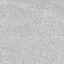

In [4]:
denoised_latents = []

@torch.no_grad()
def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
	"""
	Iteratively denoise the latent space using the diffusion model to produce an image.
	"""
	global denoised_latents

	timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)

	for t in timesteps:
		latent_model_input = torch.cat([latents] * 2)
		
		# Predict the noise residual for the current timestep
		noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)
		uncond_residual, text_cond_residual = noise_residual.chunk(2)
		guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

		# Update latents by reversing the diffusion process for the current timestep
		latents = self.scheduler.step(guided_noise_residual, t, latents)[0]
	
	denoised_latents.append(latents)

	return latents

PareDiffusionPipeline.denoise = denoise

pipe = PareDiffusionPipeline.from_pretrained(
	"stabilityai/stable-diffusion-2",
	device=torch.device("cuda"),
	dtype=torch.float16,
)
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"

for i in tqdm(range(100)):
	torch.manual_seed(i)
	image = pipe(prompt, width=512, height=512, num_inference_steps=20)

denoised_latents = [pipe.tensor_to_image(denoised_latent[0]) for denoised_latent in denoised_latents]
blended_image = denoised_latents[0]

blended_images = []
blended_images.append(blended_image)

# Blend the remaining images
for i, img in enumerate(denoised_latents[1:]):
	blended_image = Image.blend(blended_image, img, alpha=0.5 / (i + 1))
	blended_images.append(blended_image)

blended_image.save("blended_denoised_latents.png")
blended_image.show()

make_gif_with_index(blended_images, "blended_denoised_latents.gif")
